In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import gensim
import nltk
import re
from wordcloud import WordCloud
%matplotlib inline

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer  #Tokenize the text data
from tensorflow.keras.preprocessing.sequence import pad_sequences #pad_sequences is used to ensure that all sequences in a list have the same length.
from tensorflow.keras.models import Sequential #feeding our model layers
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D,Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [50]:
fake=pd.read_csv('/content/Fake.csv')
real=pd.read_csv('/content/True.csv')

In [51]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [52]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [53]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [54]:
real.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [55]:
fake.shape

(23481, 4)

In [56]:
real.shape

(21417, 4)

In [57]:
fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [58]:
real.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [59]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [60]:
real['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

<Figure size 720x432 with 0 Axes>

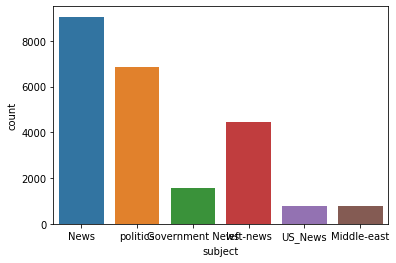

<Figure size 720x432 with 0 Axes>

In [61]:
sns.countplot(x='subject',data=fake)
plt.figure(figsize=(10,6))

<Figure size 432x432 with 0 Axes>

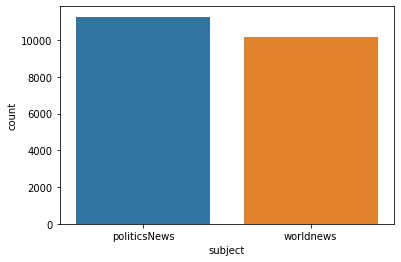

<Figure size 432x432 with 0 Axes>

In [62]:
sns.countplot(x='subject',data=real)
plt.figure(figsize=(6,6))

In [63]:
text=''.join(fake['text'].tolist()) 

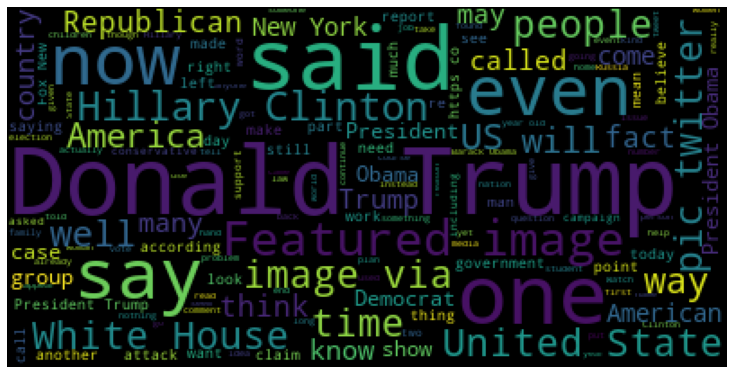

In [64]:
wordcloud=WordCloud().generate(text)
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

In [65]:
text=''.join(real['text'].tolist())

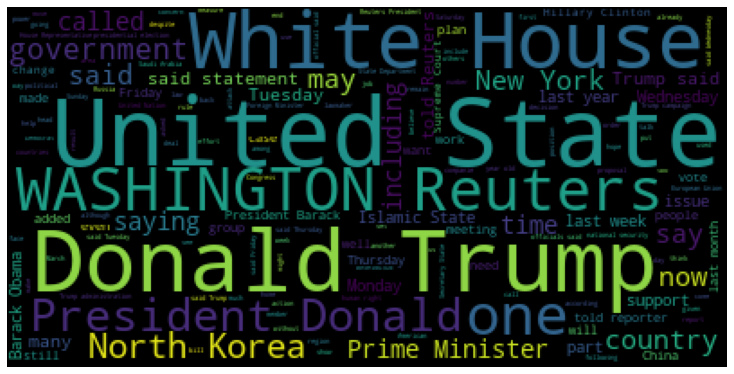

In [66]:
wordcloud=WordCloud().generate(text)
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

In [67]:
unknown_publishers=[]
for index,row in enumerate(real.text.values):
  try:
    record=row.split('-', maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
      unknown_publishers.append(index)

In [68]:
len(unknown_publishers)

222

In [69]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [70]:
real.drop(8970, axis=0) #Found Null Value so Deleting the row

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [71]:
publisher=[]

tmp_text=[]
for index,row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
  else:
    record=row.split('-' ,maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [72]:
real['publisher']=publisher
real['text']=tmp_text

In [73]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [74]:
real.shape

(21417, 5)

In [75]:
empty_fake_index=[index for index , text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [76]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [77]:
real['text']=real['title'] + " " + real['text']
fake['text']=fake['title'] + " " + fake['text']

In [78]:
real['text']= real['text'].apply(lambda x: str(x).lower())
fake['text']= fake['text'].apply(lambda x: str(x).lower())

In [79]:
real['class']=0
fake['class']=1

In [80]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [81]:
real=real[['text','class']]

In [82]:
fake=fake[['text','class']]

In [83]:
data= real.append(fake, ignore_index=True)

In [84]:
data.sample(5)

,text,class
1118,white and male: broader bureaucracy mirrors tr...,0
787,house democrat calls gop clinton probe scheme ...,0
29230,"bette midler slams trump, rubio, and terrible...",1
4799,u.s. reverses course and offers new dates for ...,0
8761,new u.s. bill to tax financial trading brings ...,0


In [85]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstal

     |████████████████████████████████| 12.0 MB 4.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-u9r719_x
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-u9r719_x
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11754 sha256=f48db6fdbaf8a9d07a57584a0770ddedaacbf4ee9e30f0130b2e198efe7ef99e
  Stored in directory: /tmp/pip-ephem-wheel-cache-dbh5hdme/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [86]:
import preprocess_kgptalkie as ps

In [87]:
data['text']=data['text'].apply(lambda x: ps.remove_special_chars(x))

In [88]:
#Word2Vector Conversion

import gensim
y= data['class'].values

In [98]:
x= [d.split() for d in data['text'].tolist()]
print(X[0])  #CONVERTS INTO LIST OF LIST DATA

[18, 30, 473, 480, 10667, 133, 8089, 40, 1375, 5172, 1, 419, 3, 4, 301, 79, 6312, 6, 1, 30, 189, 29, 773, 26, 279, 9, 4, 1107, 2956, 3, 1, 124, 954, 2, 447, 9, 184, 1193, 173, 394, 4, 1375, 301, 8, 342, 5, 1110, 473, 7805, 6, 1188, 6, 1764, 16, 4, 3407, 7897, 141, 164, 320, 133, 30, 798, 921, 7806, 675, 8, 2010, 476, 1, 383, 1761, 4, 559, 589, 8, 168, 691, 50, 408, 28, 17340, 2, 89, 1352, 65, 6, 410, 60, 32, 776, 25, 1, 8090, 8, 203, 408, 39, 1438, 350, 2, 929, 4, 168, 473, 6, 4, 480, 304, 2, 22, 1957, 2, 80, 426, 170, 18, 313, 208, 107, 18, 1, 515, 570, 96, 1781, 1504, 6, 50, 133, 39, 1072, 2, 377, 349, 3, 189, 37, 68, 14, 5, 19, 133, 182, 4, 379, 473, 959, 6, 169, 691, 110, 196, 62, 182, 12265, 3554, 9, 17100, 13038, 691, 8, 1001, 7, 149, 988, 4132, 1085, 1463, 166, 306, 5, 1380, 1204, 1, 14, 151, 21, 294, 44, 1347, 2, 122, 45, 135, 2, 959, 17100, 13038, 691, 20, 38, 1084, 137, 7806, 594, 3, 1, 758, 34, 3471, 67, 769, 2121, 13, 8, 1, 330, 99, 196, 28, 183, 1648, 24, 457, 35, 230, 2, 

In [99]:
DIM=100
w2v_model= gensim.models.Word2Vec(sentences=x,size=DIM, window=10, min_count=1)

In [100]:
len(w2v_model.wv.vocab)

231911

In [101]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(x)

In [102]:
x= tokenizer.texts_to_sequences(x) #X from text data converted to sequence of number

In [103]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

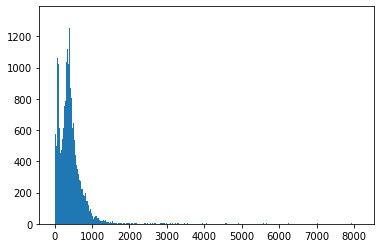

In [104]:
plt.hist([len(x) for x in X] ,bins=700)   #len(x)--how many words present in each row
plt.show()     # shows us no of words present in news

In [105]:
#Checking for numbers

number = np.array([len(x) for x in x])
len(number[number>1000])

1584

In [107]:
maxlen=1000
x= pad_sequences(x, maxlen=maxlen)

In [108]:
len(X[101])

1000

In [113]:
vocab_size = len(tokenizer.word_index) +1
vocab=tokenizer.word_index

In [115]:
def get_weight_matrix(model):
    weight_matrix=np.zeros((vocab_size,DIM))
    
    for word,i in vocab.items():
      weight_matrix[i]= model.wv[word]
    return weight_matrix

In [116]:
embedding_vectors=get_weight_matrix(w2v_model)

In [117]:
embedding_vectors.shape

(231912, 100)

In [118]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=DIM, weights=[embedding_vectors],trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])



In [119]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         23191200  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 23,308,577
Trainable params: 117,377
Non-trainable params: 23,191,200
_________________________________________________________________


In [120]:
x_train,x_test,y_train,y_test=train_test_split(x,y)
model.fit(x_train,y_train,validation_split=0.3,epochs=6)

Epoch 1/6
737/737 [==============================] - 128s 164ms/step - loss: 0.1543 - acc: 0.9432 - val_loss: 0.0824 - val_acc: 0.9740
Epoch 2/6
737/737 [==============================] - 121s 164ms/step - loss: 0.0750 - acc: 0.9752 - val_loss: 0.0818 - val_acc: 0.9734
Epoch 3/6
737/737 [==============================] - 121s 164ms/step - loss: 0.0463 - acc: 0.9852 - val_loss: 0.0326 - val_acc: 0.9902
Epoch 4/6
737/737 [==============================] - 121s 164ms/step - loss: 0.0334 - acc: 0.9885 - val_loss: 0.0597 - val_acc: 0.9791
Epoch 5/6
737/737 [==============================] - 121s 164ms/step - loss: 0.0208 - acc: 0.9930 - val_loss: 0.0290 - val_acc: 0.9906
Epoch 6/6
737/737 [==============================] - 120s 163ms/step - loss: 0.0124 - acc: 0.9964 - val_loss: 0.0200 - val_acc: 0.9944


In [121]:
y_pred=(model.predict(x_test)>=0.5).astype(int)
accuracy_score(y_test,y_pred)

0.9942093541202672

In [122]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5364
           1       1.00      0.99      0.99      5861

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [143]:
x=['this is a news']

In [144]:
x_test

array([[   0,    0,    0, ..., 1867,  882,  411],
       [   0,    0,    0, ...,  976,  852, 2197],
       [   0,    0,    0, ..., 1106, 8395,  478],
       ...,
       [   0,    0,    0, ...,    6,    7,   59],
       [   0,    0,    0, ...,   11, 1391,  487],
       [   0,    0,    0, ...,  535,   12,  403]], dtype=int32)

In [152]:
x= ['Punjab chief minister Charanjit Singh Channi on Saturday arrived at Governor Banwarilal Purohit']
x=(tokenizer.texts_to_sequences(x))
x=pad_sequences(x,maxlen=maxlen)

In [153]:
(model.predict(x)>=0.5).astype(int)

array([[0]])